### Memory occupation in array

In [12]:
import json
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

In [13]:
def analyze_memory_occupation(json_file_path):
    """
    Analyze memory occupation of COMP_OP operations from JSON file
    
    Args:
        json_file_path (str): Path to the JSON file
    
    Returns:
        dict: Analysis results with arrays and statistics
    """
    
    # Read JSON file
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    
    # Extract COMP_OP entries
    comp_ops = []
    
    for item in data['workload']:
        if item.get('type') == 'COMP_OP':
            comp_ops.append({
                'id': item['id'],
                'size': item['size'],
                'node': item['node'],
                'layer_id': item.get('layer_id', 0),
                'weight_size': item.get('weight_size', 0)
            })
    
    # Create numpy arrays for easier manipulation
    ids = np.array([op['id'] for op in comp_ops])
    sizes = np.array([op['size'] for op in comp_ops])
    nodes = np.array([op['node'] for op in comp_ops])
    layers = np.array([op['layer_id'] for op in comp_ops])
    weights = np.array([op['weight_size'] for op in comp_ops])
    
    # Create DataFrame for easier analysis
    df = pd.DataFrame({
        'id': ids,
        'size': sizes,
        'node': nodes,
        'layer_id': layers,
        'weight_size': weights
    })
    
    # Group by node for memory analysis
    node_memory = defaultdict(lambda: {'total_size': 0, 'total_weight': 0, 'operations': []})
    
    for op in comp_ops:
        node_memory[op['node']]['total_size'] += op['size']
        node_memory[op['node']]['total_weight'] += op['weight_size']
        node_memory[op['node']]['operations'].append(op['id'])
    
    # Print analysis results
    print("="*60)
    print("COMP_OP MEMORY OCCUPATION ANALYSIS")
    print("="*60)
    
    print(f"\nTotal COMP_OP operations found: {len(comp_ops)}")
    print(f"Total memory usage: {np.sum(sizes)}")
    print(f"Total weight usage: {np.sum(weights)}")
    print(f"Unique nodes: {len(np.unique(nodes))}")
    
    #print("\nCOMP_OP Operations Details:")
    #print("-"*50)
    #print("ID\tSize\tNode\tLayer\tWeight")
    #for op in comp_ops:
    #    print(f"{op['id']}\t{op['size']}\t{op['node']}\t{op['layer_id']}\t{op['weight_size']}")
    
    print("\nMemory Occupation by Node:")
    print("-"*50)
    print("Node\tTotal Size\tTotal Weight\tOp Count\tOperation IDs")
    for node in sorted(node_memory.keys()):
        mem = node_memory[node]
        ops_str = ', '.join(map(str, mem['operations']))
        print(f"{node}\t{mem['total_size']}\t{mem['total_weight']}\t{len(mem['operations'])}\t[{ops_str}]")
    
    # Statistics
    print("\nStatistics:")
    print("-"*30)
    print(f"Average operation size: {np.mean(sizes):.2f}")
    print(f"Max operation size: {np.max(sizes)}")
    print(f"Min operation size: {np.min(sizes)}")
    print(f"Standard deviation: {np.std(sizes):.2f}")
    
    # Node load balance analysis
    node_loads = [node_memory[node]['total_size'] for node in node_memory.keys()]
    print(f"\nNode Load Balance:")
    print(f"Most loaded node: {max(node_loads)} units")
    print(f"Least loaded node: {min(node_loads)} units")
    print(f"Load imbalance ratio: {max(node_loads)/min(node_loads):.2f}")
    
    # Return structured data
    return {
        'arrays': {
            'ids': ids,
            'sizes': sizes,
            'nodes': nodes,
            'layers': layers,
            'weights': weights
        },
        'dataframe': df,
        'node_memory': dict(node_memory),
        'statistics': {
            'total_operations': len(comp_ops),
            'total_size': np.sum(sizes),
            'total_weight': np.sum(weights),
            'avg_size': np.mean(sizes),
            'max_size': np.max(sizes),
            'min_size': np.min(sizes),
            'std_size': np.std(sizes),
            'unique_nodes': len(np.unique(nodes))
        }
    }

In [14]:
def plot_memory_distribution(results):
    """
    Plot memory distribution across nodes
    """    
    node_memory = results['node_memory']
    nodes = list(node_memory.keys())
    sizes = [node_memory[node]['total_size'] for node in nodes]
    
    plt.figure(figsize=(10, 6))
    plt.bar(nodes, sizes, color='skyblue', alpha=0.7)
    plt.xlabel('Node')
    plt.ylabel('Total Memory Size')
    plt.title('Memory Distribution Across Nodes')
    plt.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(sizes):
        plt.text(nodes[i], v + max(sizes)*0.01, str(v), ha='center')
    
    plt.tight_layout()
    plt.show()

In [35]:
# Convert memory values based on unit
def convert_memory(value, unit):
    if unit == 'KB':
        return value / 1024
    elif unit == 'MB':
        return value / (1024 * 1024)
    else:  # 'B'
        return value

In [36]:
def plot_memory_distribution_2d(results, k=4, n=2, unit='B'):
    """
    Plot memory distribution as a 2D grid using imshow
    Node 0 is positioned at bottom-left corner
    
    Args:
        results: Results dictionary from analyze_memory_occupation
        k: Grid dimension (k x k grid, default 4 for 4x4 = 16 nodes)
        n: Number of dimensions (default 2 for 2D torus)
        unit: Memory unit to display ('B', 'KB', 'MB')
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create grid based on k parameter
    grid_size = k
    total_nodes = grid_size ** n
    
    # Initialize memory grid
    memory_grid = np.zeros((grid_size, grid_size))
    
    # Fill grid with memory values
    node_memory = results['node_memory']
    
    for node_id, memory_data in node_memory.items():
        # Convert node ID to 2D coordinates
        row = node_id // grid_size
        col = node_id % grid_size
        
        # Store total memory size
        memory_grid[row, col] = memory_data['total_size']
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Use imshow with origin='lower' to put node 0 at bottom-left
    im = plt.imshow(convert_memory(memory_grid, unit), cmap='plasma', origin='lower', 
                    interpolation='nearest', aspect='equal')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label(f'Memory Size ({unit})', rotation=270, labelpad=20)
    
    # Set ticks and labels
    plt.xticks(range(grid_size))
    plt.yticks(range(grid_size))
    
    # Add text annotations for each cell
    for i in range(grid_size):
        for j in range(grid_size):
            node_id = i * grid_size + j
            memory_val = memory_grid[i, j]
            
            # Convert memory value for display
            display_val = convert_memory(memory_val, unit)
            
            # Smart text color selection based on colormap value
            normalized_val = memory_val / np.max(memory_grid) if np.max(memory_grid) > 0 else 0
            
            # For plasma colormap: use white text for dark regions, black for bright regions
            # Plasma goes from dark purple (0) to bright yellow (1)
            if normalized_val < 0.4:  # Dark purple/blue region
                text_color = 'white'
            elif normalized_val > 0.95:  # Bright yellow region  
                text_color = 'black'
            else:  # Middle regions (pink/orange)
                text_color = 'white'
            
            # Format display value based on unit
            if unit == 'B':
                display_text = f'{int(display_val)}'
            elif unit == 'KB':
                display_text = f'{display_val:.1f}'
            else:  # MB
                display_text = f'{display_val:.2f}'
            
            # Add only the memory value (no node ID)
            plt.text(j, i, display_text, 
                    ha='center', va='center', color=text_color, 
                    fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print grid mapping for verification
    print(f"\nGrid mapping (for {grid_size}x{grid_size} grid) in {unit}:")
    for i in range(grid_size-1, -1, -1):  # Print from top row to bottom
        row_str = ""
        for j in range(grid_size):
            node_id = i * grid_size + j
            if node_id in node_memory:
                memory_val = node_memory[node_id]['total_size']
                display_val = convert_memory(memory_val, unit)
                if unit == 'B':
                    row_str += f"{int(display_val):6} "
                elif unit == 'KB':
                    row_str += f"{display_val:6.1f} "
                else:  # MB
                    row_str += f"{display_val:6.2f} "
            else:
                row_str += "     0 "
        print(row_str)

COMP_OP MEMORY OCCUPATION ANALYSIS

Total COMP_OP operations found: 388
Total memory usage: 132732
Total weight usage: 50658
Unique nodes: 16

Memory Occupation by Node:
--------------------------------------------------
Node	Total Size	Total Weight	Op Count	Operation IDs
0	7658	2717	22	[0, 20, 91, 100, 125, 126, 142, 143, 187, 191, 206, 223, 240, 244, 262, 264, 301, 306, 336, 349, 360, 384]
1	8204	3126	25	[1, 25, 35, 38, 95, 98, 139, 140, 141, 147, 153, 159, 169, 220, 235, 256, 277, 278, 287, 303, 333, 348, 365, 375, 380]
2	9343	3236	27	[6, 13, 15, 17, 27, 37, 39, 68, 73, 76, 97, 99, 163, 164, 210, 236, 246, 257, 269, 275, 279, 294, 312, 328, 340, 354, 364]
3	7695	3513	18	[8, 67, 82, 90, 124, 127, 128, 162, 208, 243, 263, 268, 295, 315, 317, 329, 342, 386]
4	7718	2938	25	[7, 18, 42, 43, 86, 110, 112, 149, 151, 152, 167, 171, 188, 192, 207, 224, 230, 261, 266, 280, 289, 304, 322, 332, 381]
5	9482	3249	27	[5, 10, 29, 30, 31, 36, 53, 56, 75, 94, 104, 106, 108, 166, 174, 211, 226, 229, 24

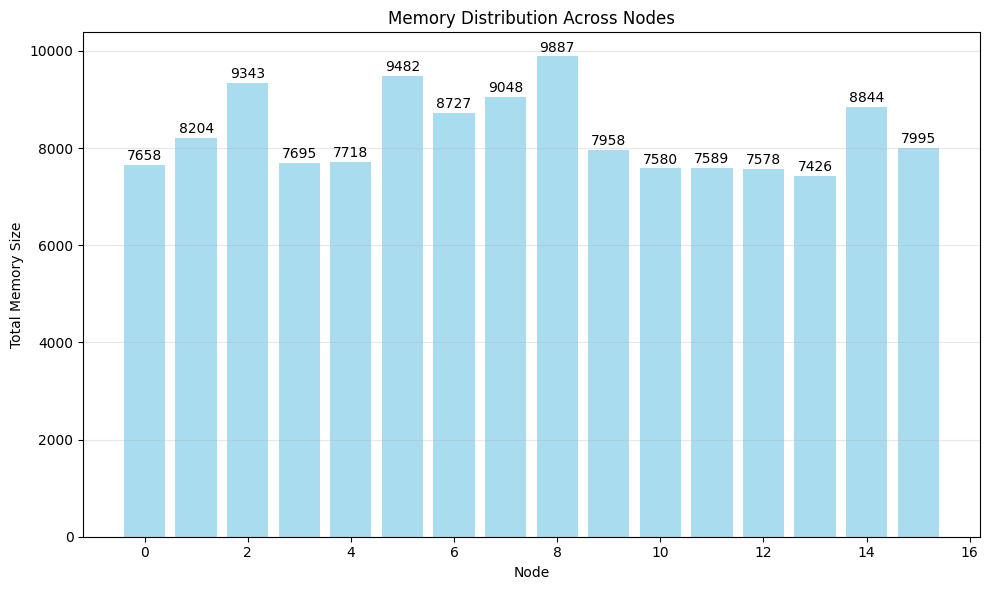

In [37]:
# Replace 'your_file.json' with your actual file path
json_file = '../data/ACO_LeNet4_run_aray_19_2025-07-11_17-13-09/best_solution.json'  # or 'your_file.json'
verbose = False
try:
    results = analyze_memory_occupation(json_file)
    
    if verbose:
        # Access the arrays
        print("\n" + "="*60)
        print("ACCESSING THE DATA ARRAYS:")
        print("="*60)
        print("IDs array:", results['arrays']['ids'])
        print("Sizes array:", results['arrays']['sizes'])
        print("Nodes array:", results['arrays']['nodes'])
        print("Layers array:", results['arrays']['layers'])
        print("Weights array:", results['arrays']['weights'])
    
    # Optional: Create visualization
    plot_memory_distribution(results)
    
except FileNotFoundError:
    print(f"Error: File '{json_file}' not found.")
    print("Please update the file path in the script.")
except json.JSONDecodeError:
    print("Error: Invalid JSON format in the file.")
except Exception as e:
    print(f"Error: {e}")

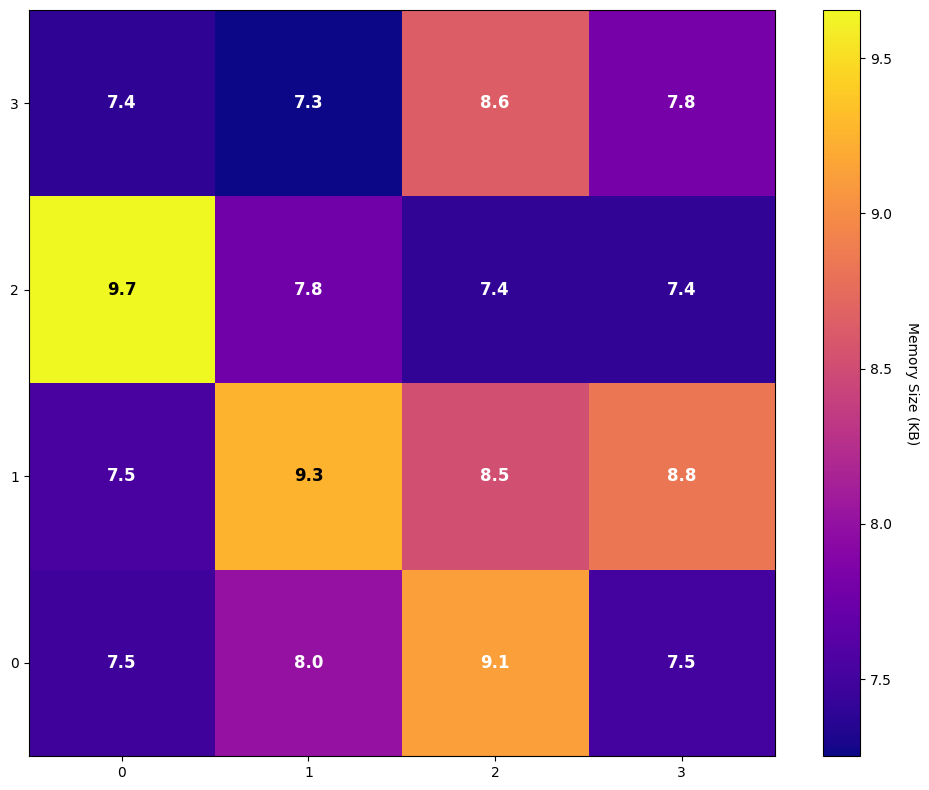


Grid mapping (for 4x4 grid) in KB:
   7.4    7.3    8.6    7.8 
   9.7    7.8    7.4    7.4 
   7.5    9.3    8.5    8.8 
   7.5    8.0    9.1    7.5 


In [38]:
plot_memory_distribution_2d(results, k=4, n=2, unit='KB')